In [56]:
## 设置hf-mirror镜像站，用于下载bert-base-chinese模型
import os
os.environ['HF_ENDPOINT']='https://hf-mirror.com/'

In [57]:
# 也可以直接用huggingface-cli命令行下载
#! pip install -U huggingface_hub
#! huggingface-cli download bert-base-chinese --local-dir bert-base-chinese

In [58]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

device='cuda:0'
# 加载预训练的bert-base-chinese模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2).to(device)  # 假设是二分类情感分析任务

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 用BertForSequenceClassification类加载，相当于加载了Bert本体和分类头
BertForSequenceClassification = Bert + dropout + linear

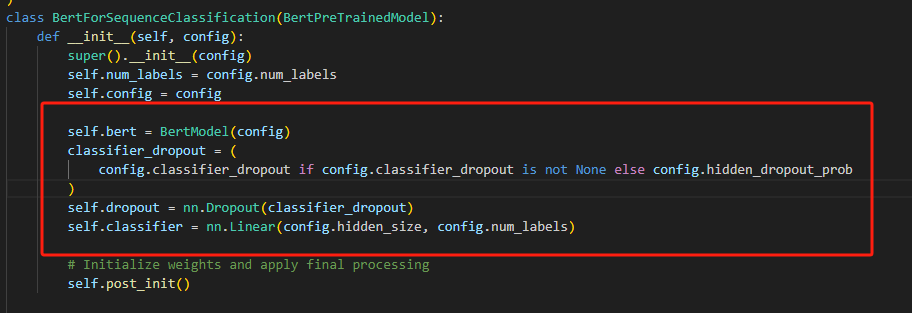

forward阶段也是如此  
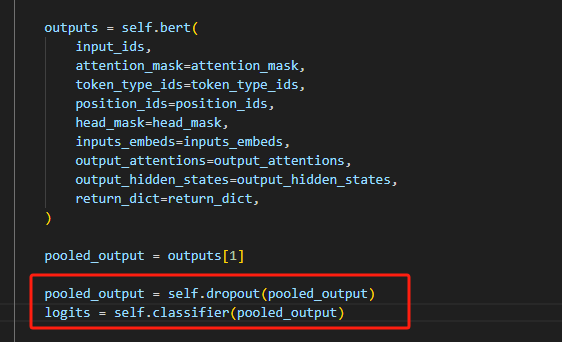  
通过看bert源码，这里的pooler_output就是对bert encode出的第一个位置的token也就是[CLS]进行了linear和tanh
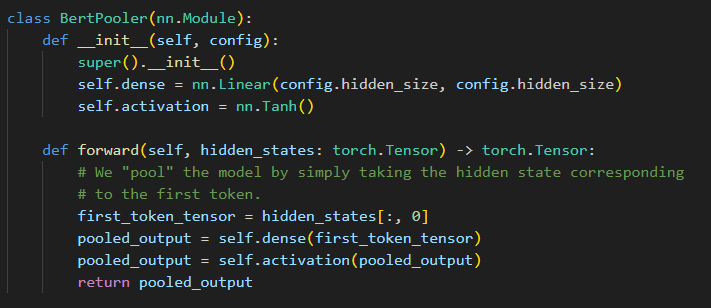

In [59]:
# 示例数据
texts = [
    "今天的天气真好，心情也特别好！",
    "这本书非常精彩，读完让我感触颇深！",
    "我终于完成了项目，感觉特别有成就感！",
    "和朋友们一起出去玩，真是太开心了！",
    "昨晚的演唱会超棒，歌手真是太有才了！",
    "我刚买了一部新手机，功能超强，真是太喜欢了！",
    "今天吃了特别好吃的火锅，太满足了！",
    "我和家人一起度过了一个美好的周末，非常温馨！",
    "今天工作顺利，老板夸奖了我，心情特别好！",
    "这部电影太感人了，结局让人热泪盈眶！",
    "今天下雨了，心情很低落，什么都不想做。",
    "这部电影真是浪费时间，剧情毫无亮点。",
    "我的手机坏了，真是倒霉，心情差到极点。",
    "工作压力太大，今天完全做不完任务，真的很沮丧。",
    "今天和朋友吵架了，心里很难受。",
    "这本书太无聊了，完全没看下去的兴趣。",
    "下班后累得不行，回家只想躺着，不想说话。",
    "昨天的演出太失望了，音乐和灯光都不好，完全不值票价。",
    "我刚刚被老板批评了，心情极差，完全没有动力做事。",
    "今天下班很晚，饿得不行，结果晚餐又没做成，真是糟糕的一天。"
]
# 1表示积极的情感，2表示消极的情感
labels = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
classes={1:"积极",0:"消极"}
print(len(texts),len(labels))

20 20


In [60]:
# 一开始预测错误
@torch.inference_mode()
def predict(model,tokenizer,sentence):
    input_ids = tokenizer.encode_plus(sentence,return_tensors='pt').to(device)
    #print(model.bert(**input_ids)[1].shape)
    output=model(**input_ids)
    logits=output.logits
    return classes[torch.argmax(logits).item()]
predict(model,tokenizer,sentence='我今天高兴得很')

'积极'

In [61]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

train_ids = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
# 这里是整个数据集一起tokenize。所有句子会被填充padding到一个数据集中最大的序列长度
# 如果数据集较大的话，一个batch一个batch的tokenize会比较好
test_ids = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt')
train_labels=torch.tensor(train_labels)
test_labels=torch.tensor(test_labels)
print(test_ids['input_ids'])
print(test_ids['attention_mask'])

tensor([[ 101, 2769, 1469, 2157,  782,  671, 6629, 2428, 6814,  749,  671,  702,
         5401, 1962, 4638, 1453, 3314, 8024, 7478, 2382, 3946, 7678, 8013,  102,
            0,    0,    0,    0],
        [ 101, 3219, 1921, 4638, 4028, 1139, 1922, 1927, 3307,  749, 8024, 7509,
          727, 1469, 4128, 1045, 6963,  679, 1962, 8024, 2130, 1059,  679,  966,
         4873,  817,  511,  102],
        [ 101, 6821, 3315,  741, 7478, 2382, 5125, 2506, 8024, 6438, 2130, 6375,
         2769, 2697, 6239, 7567, 3918, 8013,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 101, 2769, 1157,  743,  749,  671, 6956, 3173, 2797, 3322, 8024, 1216,
         5543, 6631, 2487, 8024, 4696, 3221, 1922, 1599, 3614,  749, 8013,  102,
            0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1],
        [

In [62]:
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
# 创建数据集
train_dataset = TensorDataset(train_ids['input_ids'], train_ids['attention_mask'], train_labels)
test_dataset = TensorDataset(test_ids['input_ids'], test_ids['attention_mask'], test_labels)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

# 定义优化器
optimizer = AdamW(model.parameters(), lr=1e-5)

In [ ]:
import numpy as np
def train(model,optimizer,train_loader):
    model.train()
    losses=[]
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        # transformers库会输出loss
        # 直接用这个loss进行反向传播即可
        loss = outputs.loss
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return np.array(losses).mean()
@torch.inference_mode()
def eval(model,test_dataloader):
    model.eval()
    losses=[]
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        losses.append(loss.item())
    return np.array(losses).mean()

epochs=5
for i in range(epochs):
    train_loss=train(model,optimizer,train_loader)
    eval_loss=eval(model,test_loader)
    print(f'train loss : {train_loss}, eval loss : {eval_loss}')

train loss : 0.7053853422403336, eval loss : 0.6126940548419952
train loss : 0.49577850848436356, eval loss : 0.5439418852329254
train loss : 0.3117317482829094, eval loss : 0.46652930974960327
train loss : 0.24855322390794754, eval loss : 0.3877731114625931
train loss : 0.18973333481699228, eval loss : 0.3113199472427368


In [64]:
predict(model,tokenizer,sentence='我今天高兴得很')

'积极'